In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm, truncnorm
from scipy.special import erf
from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

# Cross-survey check

/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rejected comparison in ('6dFGS', 'SDSS'): 0


/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rejected comparison in ('SDSS', 'LAMOST'): 15


/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rejected comparison in ('6dFGS', 'LAMOST'): 2


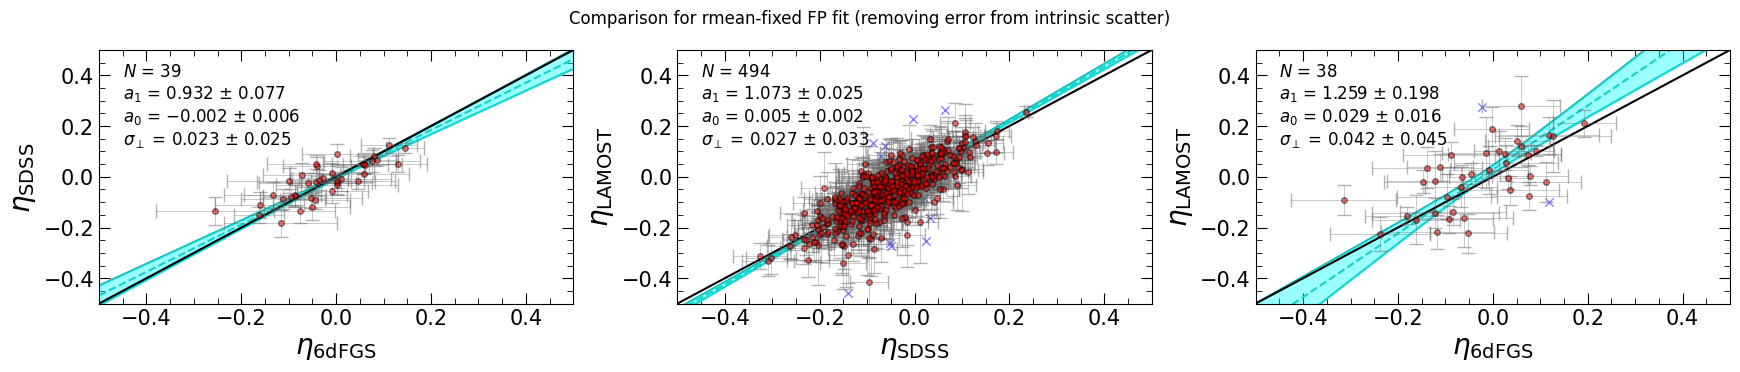

In [6]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

figure_size = 5
fig, ax = plt.subplots(ncols=3, figsize=(figure_size * 3.5, figure_size * 0.75))

ALL_COMBOS = [('6dFGS', 'SDSS'), ('SDSS', 'LAMOST'), ('6dFGS', 'LAMOST')]
for i, ax in enumerate(fig.axes):
    # Load data
    combo = ALL_COMBOS[i]
    survey1 = combo[0]
    survey2 = combo[1]

    # Load FP fits and calculate error due to intrinsic scatter of the FP
    df_ = pd.read_csv("../experiment_020_fix_abc/rmean_fixed/fp_fit.csv", index_col=0)
    fp_params = df_.loc[survey1]
    logdist_err_int_1 = fp_params["s1"] * np.sqrt(1 + fp_params["a"]**2 + fp_params["b"]**2)

    # Load FP fits and calculate error due to intrinsic scatter of the FP
    fp_params = df_.loc[survey2]
    logdist_err_int_2 = fp_params["s1"] * np.sqrt(1 + fp_params["a"]**2 + fp_params["b"]**2)

    # Load data and subtract error due to intrinsic scatter
    df1 = pd.read_csv(f"./logdists/{survey1.lower()}.csv")[["tmass", "logdist", "logdist_err"]]
    df1["logdist_err"] = np.sqrt(df1[f"logdist_err"]**2 - logdist_err_int_1**2)
    df1 = df1[~(df1["logdist_err"].isna())]

    df2 = pd.read_csv(f"./logdists/{survey2.lower()}.csv")[["tmass", "logdist", "logdist_err"]]
    # df2.rename({"logdist_rmean_fixed": "logdist", "logdist_err_rmean_fixed": "logdist_err"}, axis=1, inplace=True)
    df2["logdist_err"] = np.sqrt(df2[f"logdist_err"]**2 - logdist_err_int_2**2)
    df2 = df2[~(df2["logdist_err"].isna())]

    # Merge the two samples
    df = df1.merge(df2, on='tmass', how='inner')

    # Apply sigma clipping
    df["chisq"] = np.absolute(df[f"logdist_x"] - df[f"logdist_y"]) / np.sqrt(df["logdist_err_x"]**2 + df["logdist_err_y"]**2)
    df_rejects = df[df["chisq"] > 2.0]
    print(f"Rejected comparison in {combo}: {len(df_rejects)}")
    df = df[df["chisq"] <= 2.0]

    ndata = len(df)
    x = df[f"logdist_x"].to_numpy()
    xerr = df[f"logdist_err_x"].to_numpy()
    y = df[f"logdist_y"].to_numpy()
    yerr = df[f"logdist_err_y"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_x"], df_rejects[f"logdist_y"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r"$\eta_\mathrm{survey1}$".replace("survey1", survey1), fontsize=20)
    ax.set_ylabel(r"$\eta_\mathrm{survey2}$".replace("survey2", survey2), fontsize=20)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.05, 0.95, text_, transform=ax.transAxes, fontsize=12, 
         verticalalignment='top', horizontalalignment='left')
    
fig.suptitle("Comparison for rmean-fixed FP fit (removing error from intrinsic scatter)")
fig.tight_layout()
# fig.savefig('./rmean_fixed.png', bbox_inches='tight', dpi=300)

# North-South Comparison

/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Rejected comparison: 0


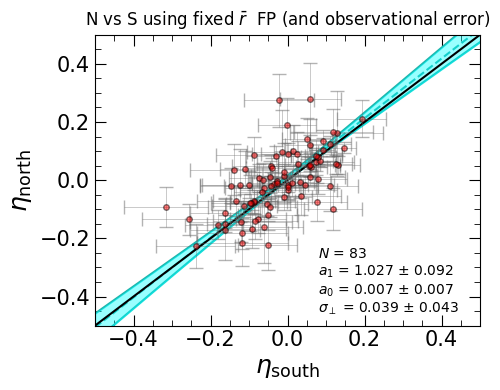

In [7]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(figsize=(5, 4))
ax_titles = ['without PV model']

for i, datapath in enumerate(['./logdists/']):

    # Load northern surveys (SDSS and LAMOST) and overwrite their errors
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:

        # Load FP fit and calculate intrinsic error
        df_params = pd.read_csv("./fp_fits.csv", index_col=0)
        fp_params = df_params.loc[survey.upper()]
        logdist_err_int = fp_params["s1"] * np.sqrt(1 + fp_params["a"]**2 + fp_params["b"]**2)

        df_temp = pd.read_csv(datapath + survey + '.csv')[['tmass', 'ra', 'dec', f'logdist', f'logdist_err']]
        df_temp[f"logdist_err"] = np.sqrt(df_temp[f"logdist_err"]**2 - logdist_err_int**2)
        df_temp = df_temp[~(df_temp[f"logdist_err"].isna())]
        df_north = pd.concat([df_north, df_temp])

    # Load 6dFGS FP fit and calculate intrinsic error
    survey = "6dFGS"
    df_params = pd.read_csv("./fp_fits.csv", index_col=0)
    fp_params = df_params.loc[survey]
    logdist_err_int = fp_params["s1"] * np.sqrt(1 + fp_params["a"]**2 + fp_params["b"]**2)

    # Load 6dFGS data and overwrite error (use observational error)
    df_south = pd.read_csv(datapath + '6dfgs.csv')[['tmass', f'logdist', f'logdist_err']]
    df_south[f"logdist_err"] = np.sqrt(df_south[f"logdist_err"]**2 - logdist_err_int**2)
    df_south = df_south[~(df_south[f"logdist_err"].isna())]

    # Combine northern and southern sample
    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_north"] - df[f"logdist_south"]) / np.sqrt(df[f"logdist_err_north"]**2 + df[f"logdist_err_south"]**2)

    df_rejects = df[df["chisq"] > 999]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 999]

    ndata = len(df)
    x = df[f"logdist_south"].to_numpy()
    xerr = df[f"logdist_err_south"].to_numpy()
    y = df[f"logdist_north"].to_numpy()
    yerr = df[f"logdist_err_north"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_south"], df_rejects[f"logdist_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    # ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.58, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.axes[0].set_title(r"N vs S using fixed $\bar{r}$  FP (and observational error)")
fig.tight_layout()
# fig.savefig('./north_vs_south_rmean_fixed_fp.png', bbox_inches='tight', dpi=300)

Rejected comparison: 0


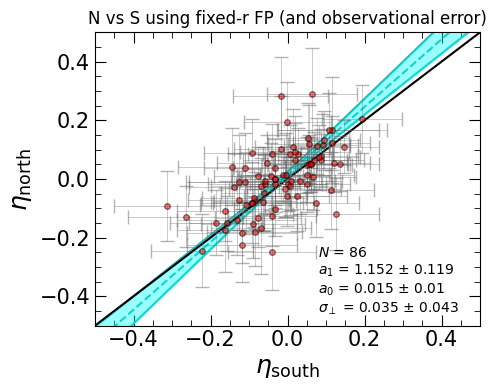

In [50]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

fig, axs = plt.subplots(figsize=(5, 4))
ax_titles = ['without PV model']

for i, datapath in enumerate(['../experiment_020_fix_abc/rmean_fixed/']):

    # Load northern surveys (SDSS and LAMOST) and overwrite their errors
    df_north = pd.DataFrame()
    for survey in ['sdss', 'lamost']:

        # Load FP fit and calculate intrinsic error
        df_params = pd.read_csv("../experiment_020_fix_abc/rmean_fixed/fp_fit.csv", index_col=0)
        fp_params = df_params.loc[survey.upper()]
        logdist_err_int = fp_params["s1"] * np.sqrt(1 + fp_params["a"]**2 + fp_params["b"]**2)

        df_temp = pd.read_csv(datapath + survey + '.csv')[['tmass', 'ra', 'dec', f'logdist_rmean_fixed', f'logdist_err_rmean_fixed']]
        # df_temp[f"logdist_err_rmean_fixed"] = np.sqrt(df_temp[f"logdist_err_rmean_fixed"]**2 - logdist_err_int**2)
        df_temp = df_temp[~(df_temp[f"logdist_err_rmean_fixed"].isna())]
        df_temp = df_temp.rename({f'logdist_rmean_fixed': 'logdist', f'logdist_err_rmean_fixed': 'logdist_err'}, axis=1)
        df_north = pd.concat([df_north, df_temp])

    # Load 6dFGS FP fit and calculate intrinsic error
    survey = "6dFGS"
    df_params = pd.read_csv("../experiment_020_fix_abc/rmean_fixed/fp_fit.csv", index_col=0)
    fp_params = df_params.loc[survey]
    logdist_err_int = fp_params["s1"] * np.sqrt(1 + fp_params["a"]**2 + fp_params["b"]**2)

    # Load 6dFGS data and overwrite error (use observational error)
    df_south = pd.read_csv(datapath + '6dfgs.csv')[['tmass', f'logdist_rmean_fixed', f'logdist_err_rmean_fixed']]
    # df_south[f"logdist_err_rmean_fixed"] = np.sqrt(df_south[f"logdist_err_rmean_fixed"]**2 - logdist_err_int**2)
    df_south = df_south[~(df_south[f"logdist_err_rmean_fixed"].isna())]
    df_south = df_south.rename({f'logdist_rmean_fixed': 'logdist', f'logdist_err_rmean_fixed': 'logdist_err'}, axis=1)

    # Combine northern and southern sample
    df = df_north.merge(df_south, on='tmass', how='inner', suffixes=('_north', '_south'))
    df["chisq"] = np.absolute(df[f"logdist_north"] - df[f"logdist_south"]) / np.sqrt(df[f"logdist_err_north"]**2 + df[f"logdist_err_south"]**2)

    df_rejects = df[df["chisq"] > 999]
    print(f"Rejected comparison: {len(df_rejects)}")
    df = df[df["chisq"] <= 999]

    ndata = len(df)
    x = df[f"logdist_south"].to_numpy()
    xerr = df[f"logdist_err_south"].to_numpy()
    y = df[f"logdist_north"].to_numpy()
    yerr = df[f"logdist_err_north"].to_numpy()
    chisq = np.absolute(x - y) / np.sqrt(xerr**2 + yerr**2)

    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    myodr = ODR(mydata, linear, beta0=[1.0, 0.0])
    myoutput = myodr.run()
    # myoutput.pprint()
    m_pred, b_pred = myoutput.beta

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(myoutput.beta, myoutput.cov_beta * myoutput.res_var, n_trial).T

    x_trial = np.linspace(-0.5, 0.5, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_trial + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_trial + b_pred
    y_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_upper = np.quantile(y_trial, q=0.84, axis=0)

    # Actual data + error bars
    ax = fig.axes[i]
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ms=4, capsize=5, elinewidth=0.5, ecolor='dimgrey', mec='k', mfc='red', alpha=0.5, zorder=3)

    # Prediction + confidence intervals
    ax.plot(x_trial, y_pred, c='lightseagreen', ls="--", zorder=2)
    ax.plot(x_trial, y_upper, c='lightseagreen', ls="-", zorder=2)
    ax.plot(x_trial, y_lower, c='lightseagreen', ls="-", zorder=2)
    ax.fill_between(x_trial, y1=y_lower, y2=y_upper, color='cyan', alpha=0.4, zorder=2)

    # Rejects
    ax.scatter(df_rejects[f"logdist_south"], df_rejects[f"logdist_north"], marker="x", c="blue", lw=1., alpha=0.5, zorder=2)

    # 1-to-1 line
    ax.plot([-0.5, 0.5], [-0.5, 0.5], c='k')

    ax.set_xlabel(r'$\eta_\mathrm{south}$', fontsize=18)
    ax.set_ylabel(r'$\eta_\mathrm{north}$', fontsize=18)
    # ax.set_title(ax_titles[i], fontsize=14)

    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='both', bottom=True, top=True, left=True, right=True,  direction="in") 
    ax.tick_params(axis='both', which='both', labelsize=15, direction="in")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

    # Add text
    N_value = len(df)
    m_value = np.round(myoutput.beta[0], 3)
    m_err = np.round(myoutput.sd_beta[0], 3)
    b_value = np.round(myoutput.beta[1], 3)
    b_err = np.round(myoutput.sd_beta[1], 3)
    sigma_ortho = np.sqrt(myoutput.delta**2 + myoutput.eps**2)
    sigma_value = np.round(np.median(sigma_ortho), 3)
    sigma_err = np.round(np.std(sigma_ortho), 3)

    N_text = rf"$N$ = {N_value}"
    m_text = rf"$a_1$ = ${m_value}$ $\pm$ {m_err}"
    b_text = rf"$a_0$ = ${b_value}$ $\pm$ {b_err}"
    sigma_text = rf"$\sigma_\perp$ = {sigma_value} $\pm$ {sigma_err}"
    text_ = N_text + "\n" + m_text + "\n" + b_text + "\n" + sigma_text
    ax.text(0.58, 0.27, text_, transform=ax.transAxes, fontsize=10, 
         verticalalignment='top', horizontalalignment='left')

fig.axes[0].set_title("N vs S using fixed-r FP (and observational error)")
fig.tight_layout()
# fig.savefig('./north_vs_south_individual_fp.pdf', bbox_inches='tight', dpi=300)